<a href="https://colab.research.google.com/github/randomfunction/Pytorch/blob/main/LSTM_stockPricePrediciton_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [39]:
#load data

import yfinance as yf
df= yf.download(tickers='AAPL', period='1y', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [40]:
#close price only
prices= df['Close'].values.reshape(-1,1)

In [41]:
#normalize
scaler= MinMaxScaler()
prices= scaler.fit_transform(prices)

# print(prices)

In [42]:
#data sequences
def create_sequences(data, length):
  sequence=[]
  target=[]
  for i in range(len(data)- length):
    sequence.append(data[i:i+length])
    target.append(data[i+length])
  return np.array(sequence), np.array(target)

In [43]:
#prepare train,test data
length= 50
X, y= create_sequences(prices, length)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, shuffle=False)

In [44]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [45]:
#LSTM model

class LSTM(nn.Module):
  def __init__(self, inputsize, hiddensize, outputsize):
    super(LSTM, self).__init__()
    self.hiddensize= hiddensize

    # First LSTM layer
    self.lstm1 = nn.LSTM(inputsize, hiddensize, batch_first=True)
    self.dropout1 = nn.Dropout(0.2)

    # Second LSTM layer
    self.lstm2 = nn.LSTM(hiddensize, hiddensize, batch_first=True)
    self.dropout2 = nn.Dropout(0.2)

    # third LSTM layer
    self.lstm3 = nn.LSTM(hiddensize, hiddensize, batch_first=True)
    self.dropout3 = nn.Dropout(0.2)

    # Fully connected layer
    self.fc = nn.Linear(hiddensize, outputsize)

  def forward(self, x):
        h1 = torch.zeros(1, x.size(0), self.hiddensize).to(x.device)
        c1 = torch.zeros(1, x.size(0), self.hiddensize).to(x.device)
        h2 = torch.zeros(1, x.size(0), self.hiddensize).to(x.device)
        c2 = torch.zeros(1, x.size(0), self.hiddensize).to(x.device)
        h3 = torch.zeros(1, x.size(0), self.hiddensize).to(x.device)
        c3 = torch.zeros(1, x.size(0), self.hiddensize).to(x.device)

        out, _ = self.lstm1(x, (h1, c1))
        out = self.dropout1(out)
        out, _ = self.lstm2(out, (h2, c2))
        out = self.dropout2(out)
        out, _ = self.lstm3(out, (h3, c3))
        out = self.dropout3(out)

        # Fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [46]:
#intilaize model

#model params
inputsize=1
hiddensize=128
outputsize=1

model= LSTM(inputsize, hiddensize, outputsize)

#loss fn, optimiser
criterion= nn.MSELoss()
optimiser= torch.optim.Adam(model.parameters(), lr=0.01)

In [47]:
#Train model
epochs= 500
train_losses= []

for epoch in range(epochs):
  model.train()
  optimiser.zero_grad()
  output= model(X_train)
  loss= criterion(output, y_train)
  loss.backward()
  optimiser.step()
  train_losses.append(loss.item())

  #print details while training
  if epoch%10==0:
    print(f'Epoch: {epoch}, Loss: {loss.item()}')

Epoch: 0, Loss: 0.30354636907577515
Epoch: 10, Loss: 0.02994743548333645
Epoch: 20, Loss: 0.01771056093275547
Epoch: 30, Loss: 0.005990984849631786
Epoch: 40, Loss: 0.004282230976969004
Epoch: 50, Loss: 0.004168112762272358
Epoch: 60, Loss: 0.003202918218448758
Epoch: 70, Loss: 0.0031559327617287636
Epoch: 80, Loss: 0.003339427290484309
Epoch: 90, Loss: 0.002857448998838663
Epoch: 100, Loss: 0.003325204597786069
Epoch: 110, Loss: 0.002901857951655984
Epoch: 120, Loss: 0.003132425481453538
Epoch: 130, Loss: 0.0024126553907990456
Epoch: 140, Loss: 0.0022927296813577414
Epoch: 150, Loss: 0.002424532314762473
Epoch: 160, Loss: 0.002315271645784378
Epoch: 170, Loss: 0.002547711366787553
Epoch: 180, Loss: 0.002727122977375984
Epoch: 190, Loss: 0.002286661183461547
Epoch: 200, Loss: 0.0026158038526773453
Epoch: 210, Loss: 0.0027291500009596348
Epoch: 220, Loss: 0.002065695123746991
Epoch: 230, Loss: 0.002150489715859294
Epoch: 240, Loss: 0.0025125795509666204
Epoch: 250, Loss: 0.0022577254567

In [48]:
model.eval()
with torch.no_grad():
  test_output= model(X_test)
  test_loss= criterion(test_output, y_test)
  print(f'Test Loss: {test_loss.item()}')

Test Loss: 0.0028635954950004816


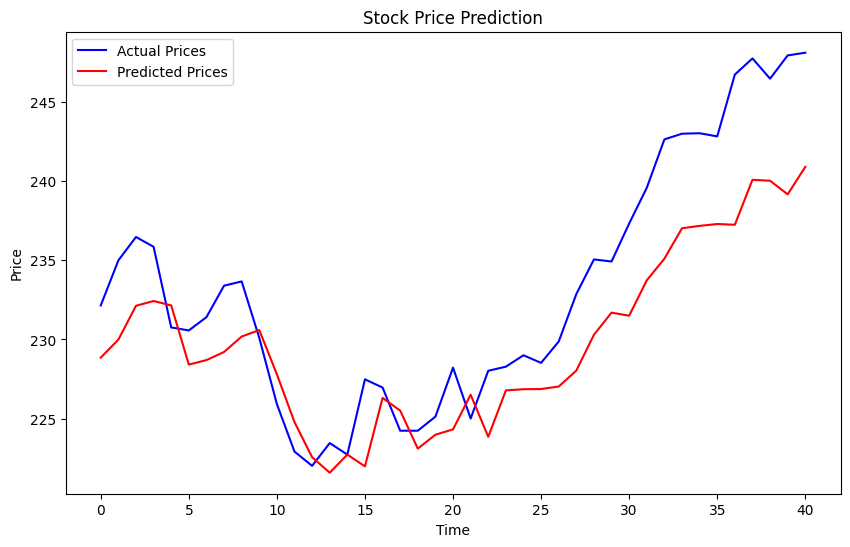

In [49]:
# Convert predictions back to original scale
test_predictions = test_output.numpy()
y_test = y_test.numpy()

test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

# Plot predictions vs. actual prices
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(test_predictions, label='Predicted Prices', color='red')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()